## CU Boulder 4604/5604

#### September 28, 2020

####  Logistic regression revisited

### Logistic Regression revisited

- Last week we learned about logistic regression and regularization
- Today, we are going modify the notebook from last week in 2 ways 

##### New stuff:
1. I filled in the missing functions from last week if you are curious. Everyone who submitted last week got full credit. These notebooks are a way to get your hands dirty with real ML code so you learn the materials more deeply. They are not a way for me to quiz you on what you know. That is what HW, quizzes, exams are for ...
2. We are going to add a regularization term to the loss function
3. We will split training data and test data, and look at the effects of regularization
4. We will introduce stochastic gradient descent. The well-known ML researcher [Dave Blei](http://www.cs.columbia.edu/~blei/) says stoachstic gradient descent is like walking from New York to Los Angeles by asking one person at a time for directions. And every person you ask for directions is drunk. Even though this seems like a bad way to get across the country, we will see that is has clear advantages
5. I changed the code from gradient ascent to gradient descent (flipping signs as needed). Recall that maximizing log likelihood is the same as minimizing negative log likelihood.

### Annoucements 

- Recall HW2 is out
- This notebook is pretty similar to HW2
- In the real world, it is OK to lean on sklearn's implementation of logistic regression
- But taking this class gives you a chance to actually understand how it works. This notebook should make the sklearn code much less mysterious

## Definitions

### L2 Norm
$\sqrt{\Sigma x_i^2}$

### L2$^2$ Norm 

$\sqrt{\Sigma x_i^2}^2 = \Sigma x_i^2$

In [1]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

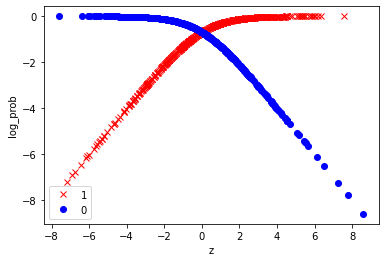

In [2]:
## Here is the logistic function, the activation function for logistic regression

def logistic(z):
    return 1/(1 + np.exp(-z))


## Let's generate some features, weights and y values and compute the loss 
## This can help you build up intuition for what is happening

def log_prob(z, y_i):
    '''
    Returns the log_prob for one point
    '''
    fz = logistic(z)
    return y_i * np.log(fz) + (1 - y_i) * np.log(1 - fz)


out = []

dim_ = 10

for _ in range(1000):
    # generate some random weights 
    w = np.random.uniform(low=-2, high=2, size=dim_)
    
    # generate some random binary features 
    x = (np.random.rand(dim_) > .5).astype(int) 
    
    # get the z score
    z = w.dot(x)

    # randomly assign y
    y = 1 if random.random() < .5 else 0
    
    # compute the loss
    loss = log_prob(z=z, y_i=y)
    
    # keep track of what is happening
    out.append({"z": z, "loss": loss, "label": y})


# Plot the results
df = pd.DataFrame(out)
    
fig, ax = plt.subplots()
ax.plot(df[df["label"] == 1]["z"], df[df["label"] == 1]["loss"], 'x', color="red", label='1')
ax.plot(df[df["label"] == 0]["z"], df[df["label"] == 0]["loss"], 'o', color="blue", label='0')
plt.xlabel("z")
plt.ylabel("log_prob")
plt.legend()
plt.show()

In [11]:
from random import uniform

def neg_log_likelihood(X, w, y):
    '''Compute the negative log likelihood'''
    L = 0
    for _x,_y in zip(X, y):
        z = w.dot(_x)
        L += log_prob(z=z, y_i=_y)
    return -1 * L


def fast_logistic(X, w):
    '''Compute the logistic function over many data points'''
    return 1/(1 + np.exp(-1 * X.dot(w)))


def grad(X, w, y, lambda_=.5):
    '''
    Return the gradient
    
    - https://web.stanford.edu/~jurafsky/slp3/5.pdf
    '''
    grad = np.zeros_like(w)
    batch_size, F = X.shape
    
    b = X * (fast_logistic(X, w) - y).reshape((batch_size, 1))

    return np.sum(b, axis=0) + (lambda_ * 2 * w)


def squared_l2_norm(x):
    '''
    $\sqrt{\Sigma x_i^2} ^ 2
    '''
    return np.sum(x ** 2)


def grad_decent(_X, _y, eta = .0001, lambda_ = 0, tolerance=1e-4, verbose=True, batch_size=None):
    '''
    - Perform gradient ascent
    - This function is basically the same as in the Adeline notebook
    - Of course, the gradient is different, because it is a different function
    '''
    N, dim = _X.shape
    w = np.random.uniform(low=-.1, high=.1, size=dim)
    last = 0
    for i in range(1000):
        this_ll = neg_log_likelihood(_X, w, _y)
        loss = this_ll + lambda_ * squared_l2_norm(w)
        if verbose:
            print("iter: {}, loss: {}, accuracy: {}".format(i, loss, accuracy(_X, w, _y)))
        if(abs(this_ll - last) < tolerance): break
        last = this_ll
        if batch_size is not None:
            w -= eta * grad(_X, w, _y, lambda_=lambda_)
        else:
            _N,F = _X.shape
            idx = np.random.randint(_N, size=batch_size)
            w -= eta * grad(_X, w, _y, lambda_=lambda_)
    return w

def prediction(X, w, threshold=.5):
    '''
    - Return a Boolean array of length N.
    - The array should be True if the weights dotted with the features for a given instance is greater than .5
    '''
    N, D = X.shape
    return X.dot(w) > threshold

def accuracy(X, w, y):
    '''
    Return a value between 0 and 1, showing the fraction of data points which have been classified correctly
    '''
    return np.mean(prediction(X, w) == y)


np.random.seed(42)

from sklearn import datasets

from sklearn.model_selection import train_test_split

iris = datasets.load_breast_cancer()

X = iris.data
y = iris.target

N, dim = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=True)

for lambda_ in [0.]:
    w = grad_decent(X_train, y_train, eta=.0000001, tolerance=.001, verbose=True, lambda_=lambda_, batch_size=None)
    test_accuracy = accuracy(X_test, w, y_test)
    train_accuracy = accuracy(X_train, w, y_train)
    print('*', lambda_, test_accuracy, train_accuracy)


iter: 0, loss: 1177.2101977547838, accuracy: 0.4014084507042254
iter: 1, loss: 208.29016510389178, accuracy: 0.778169014084507
iter: 2, loss: 614.7044694692763, accuracy: 0.4014084507042254
iter: 3, loss: 750.4479476300494, accuracy: 0.6408450704225352
iter: 4, loss: 1224.0838741120165, accuracy: 0.4014084507042254
iter: 5, loss: 173.7920665149241, accuracy: 0.8098591549295775
iter: 6, loss: 403.79325120132216, accuracy: 0.40492957746478875
iter: 7, loss: 831.403870206119, accuracy: 0.6373239436619719
iter: 8, loss: 1196.4143313639813, accuracy: 0.4014084507042254
iter: 9, loss: 179.6249396656115, accuracy: 0.8098591549295775
iter: 10, loss: 425.09608974656686, accuracy: 0.40492957746478875
iter: 11, loss: 802.5904682193302, accuracy: 0.6408450704225352
iter: 12, loss: 1156.7733036919371, accuracy: 0.4014084507042254
iter: 13, loss: 192.48768220155517, accuracy: 0.8028169014084507
iter: 14, loss: 478.63514986540304, accuracy: 0.4014084507042254
iter: 15, loss: 762.2711623235859, accura

iter: 172, loss: 120.51624127691312, accuracy: 0.7570422535211268
iter: 173, loss: 118.94092319533793, accuracy: 0.8838028169014085
iter: 174, loss: 115.85678081644602, accuracy: 0.778169014084507
iter: 175, loss: 114.75391157088734, accuracy: 0.8802816901408451
iter: 176, loss: 112.4522149787882, accuracy: 0.7816901408450704
iter: 177, loss: 111.6674783397111, accuracy: 0.8802816901408451
iter: 178, loss: 109.922512659951, accuracy: 0.7922535211267606
iter: 179, loss: 109.34969951642097, accuracy: 0.8767605633802817
iter: 180, loss: 108.00247899556788, accuracy: 0.8028169014084507
iter: 181, loss: 107.57162252958248, accuracy: 0.8661971830985915
iter: 182, loss: 106.51123094202381, accuracy: 0.8063380281690141
iter: 183, loss: 106.1769421267781, accuracy: 0.8661971830985915
iter: 184, loss: 105.32639768886432, accuracy: 0.8098591549295775
iter: 185, loss: 105.05916099254028, accuracy: 0.8661971830985915
iter: 186, loss: 104.36492010732817, accuracy: 0.8169014084507042
iter: 187, loss:

In [ ]:
Norm questions

- Complete the squared L2 norm function
- What does \lambda do? 
- What happens if you set lambda = 5000?
- Try computing the norm of w with different lambda

In [14]:
X.shape

(569, 30)

In [18]:
grad(X, w, y).shape

(30,)

In [16]:
w.shape

(30,)

In [17]:
X.shape

(569, 30)